# Interpreting ResNet Model With LRP(Layer-wise Relevance Propagation)

Layer-wise Relevance Propagation (LRP) is an explanation technique applicable to models structured as neural networks, where inputs can be `e.g. images, videos, or text`.

LRP operates by propagating the prediction $f(x)$ backwards in the neural network, by means of purposely designed local propagation rules.

LRP rules could be easily expressed in terms of matrix-vector operations. In practice, state-of-the-art neural networks such as ResNet make use of more complex layers such as convolutions and pooling. 

In this case, LRP rules are more conveniently implemented by casting the operations of the four-step procedure above as `forward` and `gradient` evaluations on these layers. These operations are readily available in neural network frameworks such as PaddlePaddle and Pytorch, and can therefore be reused for the purpose of implementing LRP. 

Here, we take the `ResNet` pretrained network for image classification.

## LRP Rules for Deep Rectifier Networks

### Basic Rule (LRP-0)
This rule redistributes in proportion to the contributions of each input to the neuron activation as they occur in Eq. below:
$$
R_j = \sum_k{\frac{a_j w_{jk}}{\sum_{0, j}{a_jw_{jk}}}R_k} 
$$

### Epsilon Rule (LRP-$\epsilon$)
A first enhancement of the basic LRP-0 rule consists of adding a small positive term in the denominator:
$$
R_j = \sum_k{\frac{a_j w_{jk}}{\epsilon + \sum_{0, j}{a_jw_{jk}}}R_k} 
$$

The role of $\epsilon$ is to absorb some relevance when the contributions to the activation of neuron k are weak or contradictory. As $\epsilon$ becomes larger, only the most salient explanation factors survive the absorption. This typically leads to explanations that are sparser in terms of input features and less noisy.

### Gamma Rule (LRP-$\gamma$)
Another enhancement which we introduce here is obtained by favoring the effect of positive contributions over negative contributions:  
$$
R_j = \sum_k{\frac{{a_j \cdot (w_{jk} + \gamma w_{jk}^+)}}{\sum_{0, j}{a_j \cdot (w_{jk} + \gamma w_{jk}^+)}}R_k} 
$$

The parameter $\gamma$ controls by how much positive contributions are favored. As $\gamma$ increases, negative contributions start to disappear. The prevalence of positive contributions has a limiting effect on how large positive and negative relevance can grow in the propagation phase. This helps to deliver more stable explanations.


## Implementing LRP Efficiently
The structure of LRP rules allows for an easy and efficient implementation. Consider the generic rule

$$
R_j = \sum_k{\frac{{a_j \rho(w_{jk})}}{\epsilon + \sum_{0, j}{a_j \rho(w_{jk})}}R_k} 
$$

of which $LRP-0/\epsilon/\gamma$ are special cases. The computation of this  ropagation rule can be decomposed in four steps:

$$
\begin{align*}
\forall_k:~z_k = {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall_k:~s_k = R_k / z_k \qquad & (\text{step }2)\\
\forall_j:~c_j = {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall_j:~R_j = a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
$$


The first step is a forward pass on a copy of the layer where the weights and biases have been applied the map $\theta \rightarrow \rho(\theta)$, to which we further add the small increment $\epsilon$. The second and fourth steps are simple element-wise operations. For the third step, one notes that $c_j$ can also be expressed as the gradient computation:
$$
c_j = [\nabla(\sum_k{z_k(\mathbf{a}) \cdot s_k)})]_j
$$
where $\mathbf{a} = (a_j)_j$ is the vector of lower-layer activations, where $z_k$ is a function of it, and where sk is instead treated as constant. This gradient can be computed via automatic differentiation, which is available in most neural networks libraries.

### $LRP-\alpha \beta$
In this repository, we use $LRP-\alpha \beta$ rule :

$$
R_j = \sum_k{(\alpha \frac{(a_j w_{jk})^+}{\sum_{0, j}{(a_j w_{jk})^+}} - \beta \frac{(a_j w_{jk})^-}{\sum_{0, j}{(a_j w_{jk})^-}}) R_k} 
$$

You can set proper value of $\alpha$ and $\beta$ to get the $LRP-0$ rule or $LRP-\gamma$ rule if you need.

In [1]:
import paddle
import interpretdl as it

## Load input image

/Users/yuantingyi/opt/anaconda3/envs/paddle2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


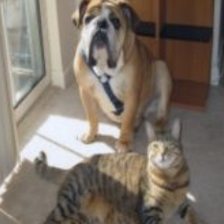

In [2]:
from PIL import Image
from interpretdl.data_processor.readers import read_image

img_path = 'assets/catdog.png'
x = Image.fromarray(read_image(img_path)[0])
x

## Load lrp model
* Supported lrp model
    - [x] resnet18
    - [x] resnet34
    - [x] resnet50
    - [x] resnet101
    - [x] resnet152
    - [x] vgg16
    - [ ] More ...

### Load model `resnet50` 

In [3]:
from assets.lrp_model import resnet50

paddle.device.set_device("cpu")
paddle_model = resnet50(pretrained=True)
# paddle_model

## Load LRP interperter

In [4]:
lrp = it.LRPCVInterpreter(paddle_model, use_cuda=False)

## Get the interpretation result
Get the interpretation result from the maximum prob label

output_prob:
```
        bull mastiff (243):  0.429
   Brabancon griffon (262):  0.048
tiger, Panthera tigr (292):  0.044
               boxer (242):  0.038
doormat, welcome mat (539):  0.029
    tabby, tabby cat (281):  0.026
           tiger cat (282):  0.023
        pug, pug-dog (254):  0.022
        Egyptian cat (285):  0.013
bloodhound, sleuthho (163):  0.012
```

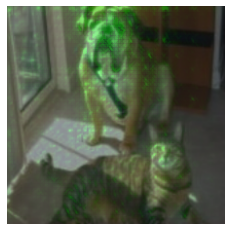

In [5]:
R = lrp.interpret(
    img_path,
    label=None,
    visual=True,
    save_path=None)

set label to `tiger cat (282)`

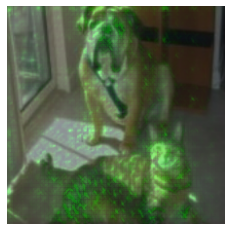

In [6]:
R = lrp.interpret(
    img_path,
    label=282,
    visual=True,
    save_path=None)

### Change model to `resnet101`

In [7]:
from assets.lrp_model import resnet101
paddle_model = resnet101(pretrained=True)

In [8]:
lrp = it.LRPCVInterpreter(paddle_model, use_cuda=False)

output prob:
```
           tiger cat (282):  0.483
    tabby, tabby cat (281):  0.212
tiger, Panthera tigr (292):  0.171
        Egyptian cat (285):  0.083
        bull mastiff (243):  0.017
doormat, welcome mat (539):  0.007
               boxer (242):  0.003
        space heater (811):  0.003
     lynx, catamount (287):  0.002
            radiator (753):  0.001
```

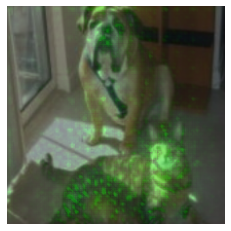

In [9]:
R = lrp.interpret(
    img_path,
    label=None,
    visual=True,
    save_path=None)

set label to `bull mastiff (243)`

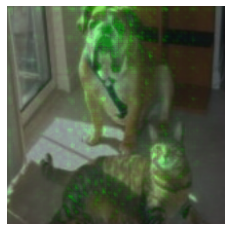

In [10]:
R = lrp.interpret(
    img_path,
    label=243,
    visual=True,
    save_path=None)

### Change model to `vgg16`

In [11]:
from assets.lrp_model import vgg16
paddle_model = vgg16(pretrained=True)

In [12]:
lrp = it.LRPCVInterpreter(paddle_model, use_cuda=False)

output prob
```
        bull mastiff (243):  0.620
tiger, Panthera tigr (292):  0.306
          Great Dane (246):  0.071
        pug, pug-dog (254):  0.003
               boxer (242):  0.000
            Leonberg (255):  0.000
bloodhound, sleuthho (163):  0.000
           tiger cat (282):  0.000
German shepherd, Ger (235):  0.000
   Brabancon griffon (262):  0.000
```

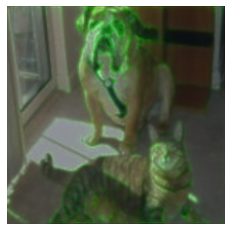

In [13]:
R = lrp.interpret(
    img_path,
    label=None,
    visual=True,
    save_path=None)

set label to `tiger cat (282)`

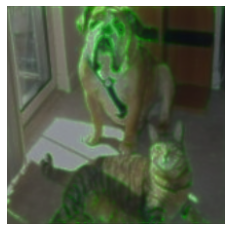

In [14]:
R = lrp.interpret(
    img_path,
    label=282,
    visual=True,
    save_path=None)